**Contents:**

 1. File selection
 2. `.text` section extraction
 3. Preliminary visualization
 4. Sampling
 5. Sample Visualization
 6. Creating the Reference
 7. Baseline Testing

**Note:**

Files with less than 10 kilobytes of machine code were excluded from both reference distribution construction and testing. This is because if a file contains less than 10k of code, most likely there will not be enough 1024-byte blocks to form a cluster that DBSCAN can detect. Small file size is a limitation of the Centrifuge toolkit.

In [220]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]
import seaborn as sns
sns.set_style("whitegrid")

sys.path.append("../../pyelftools")             # relative location of pyelftools repo cloned from github
from elftools.elf.elffile import ELFFile
from tqdm import tqdm
from scipy import stats

In [2]:
files = os.listdir("amd64")
len(files)

8733

In [3]:
files = [file for file in files if "code" not in file]
len(files)

4367

In [4]:
np.random.seed(1)
sample_files = np.random.choice(files, size=1000, replace=False)

In [5]:
code_dict = {}
path = "amd64/"
counter = 0

for file in sample_files:
    with open(path + file, "rb") as f:
        try:
            elffile = ELFFile(f)
        except:
            continue
        
        try:
            text_section_header = elffile.get_section_by_name(".text").header
        except:
            continue
        offset = text_section_header.sh_offset
        size = text_section_header.sh_size
        
        if size >= 10000: # minimum size cutoff: 10kb of machine code
            counter += 1
            f.seek(offset)
            code_dict[file] = list(f.read(size))
            if counter == 100: # number of files to select samples from
                break

In [200]:
len(code_dict.keys())

100

In [6]:
for file, code in code_dict.items():
    print("%s\t%s\t%s" %(file, str(len(code)), code[:10]))

cfe49e1b678c502b3a4e6bf9d28bbcdd	50690	[72, 141, 13, 113, 236, 0, 0, 80, 72, 141]
7f78efac408083f4af8a89d515d5b02b	102674	[72, 131, 236, 8, 232, 135, 253, 255, 255, 190]
716fd98a5966369c1a52959ff7a03f46	102914	[85, 72, 141, 53, 120, 183, 1, 0, 186, 5]
6e4c0c6b563625ebccec09bcf16ea09c	135968	[72, 57, 242, 72, 137, 240, 15, 131, 212, 0]
05b8c59d0fe8a14aa4ce89ca47d537ff	1687730	[80, 72, 139, 7, 72, 3, 120, 232, 139, 119]
2bc2f82d909321c43aa6d5694143648e	152370	[64, 128, 255, 32, 81, 116, 57, 127, 7, 64]
8199c79d8c9ae640b9c95ab00df3b845	1800450	[184, 96, 52, 70, 0, 72, 133, 192, 116, 10]
4eaf89002eda4c09b6abccffc0ec45ab	11426	[85, 83, 186, 1, 0, 0, 0, 137, 251, 72]
6399f3a483e74bb4ee2144f6ed32e51a	68530	[65, 87, 65, 86, 65, 85, 65, 84, 85, 83]
1e93c96e533c09f959bcaee2b602fd19	11922	[65, 85, 65, 84, 85, 83, 72, 129, 236, 184]
5752b3922f2ea4aa4c67829b651cdbbd	22434	[65, 87, 65, 86, 65, 85, 65, 84, 73, 137]
6b0e53be46186d3c21a951515722224f	132674	[65, 87, 65, 86, 65, 85, 65, 84, 85, 137]
513e

In [7]:
def plot_dists(dictionary):
    for file, code in dictionary.items():
        sns.distplot(code, 
                     bins = 256,
                     kde=False,
                     hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':0.1}, 
                     kde_kws={'cumulative': True},
                     norm_hist=True,
                     color="blue")
    plt.show()

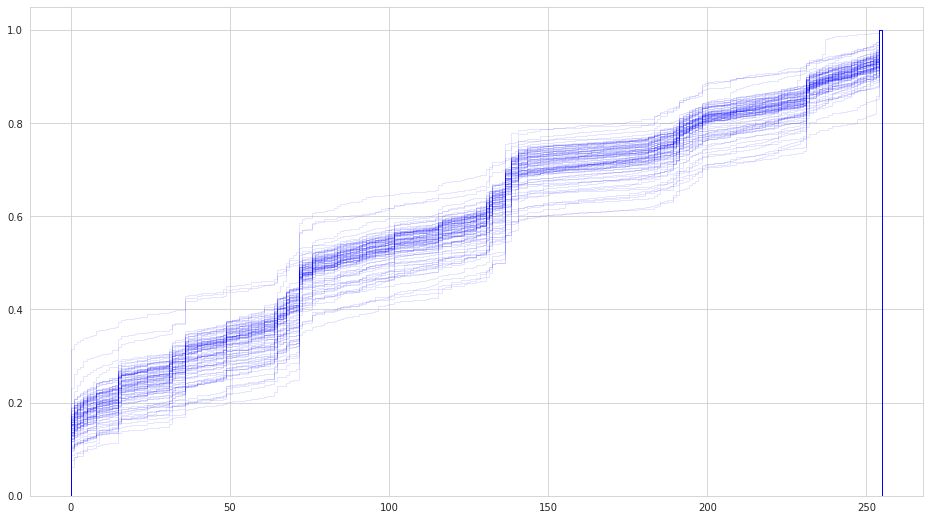

In [8]:
plot_dists(code_dict)

In [9]:
def plot_sample(sample):
    sns.distplot(sample,
                 norm_hist=True,     
                 kde=False,
                 hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':0.1, 'alpha':0.1},
                 kde_kws={'cumulative': True},  # want CDF
                 bins=256,                      
                 color="blue")

def create_code_samples(sample_size, n_rows, sample_source, plot=False):
    
    samples_df = pd.DataFrame(index=np.arange(0, n_rows), columns=[i for i in range(sample_size)])
    
    for i in tqdm(np.arange(0, n_rows)):
        sample = np.random.choice(sample_source, size=sample_size, replace=True)
        samples_df.loc[i] = sorted(sample)
        
    samples_mean = samples_df.mean(axis = 0)
    
    if plot is True:
        sns.distplot(samples_mean, norm_hist=True, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},kde_kws={'cumulative': True},bins=256,color="red")
        plt.show()    
    
    return samples_mean

In [224]:
def create_reference_distribution(code_dictionary, sample_size, n_samples):
    # create data frame to hold mean sample of each file's code
    means_df = pd.DataFrame(index=list(code_dictionary.keys()),
                            columns=[i for i in range(sample_size)])
    
    # for each file's code, store mean of the samples in data frame
    for file, code in code_dictionary.items():
        means_df.loc[file] = create_code_samples(sample_size,
                                                 n_samples,
                                                 code)
    # average all samples means together
    mean = means_df.mean(axis = 0)
    median = means_df.median(axis = 0)
    return mean, median

In [11]:
mean, median = create_reference_distribution(code_dict, 1000, 1000)

100%|██████████| 1000/1000 [00:43<00:00, 23.09it/s]


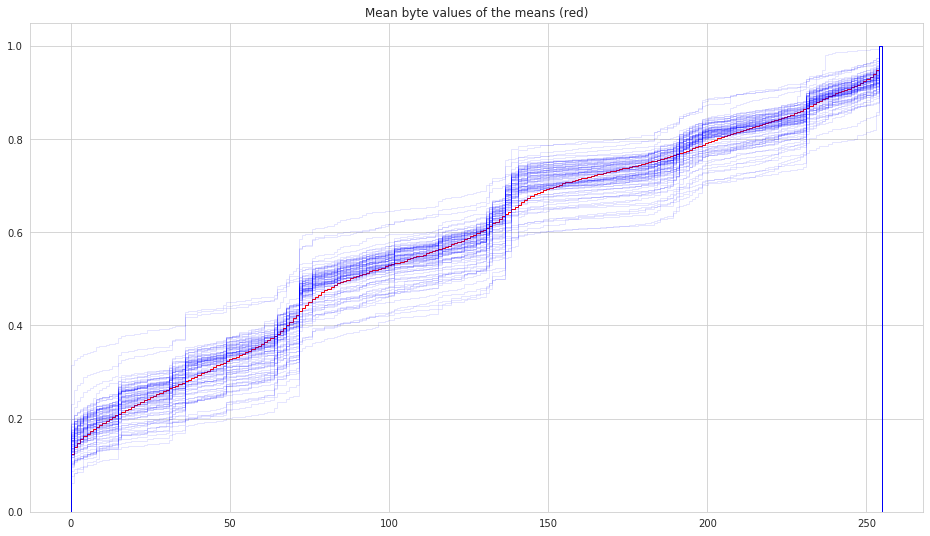

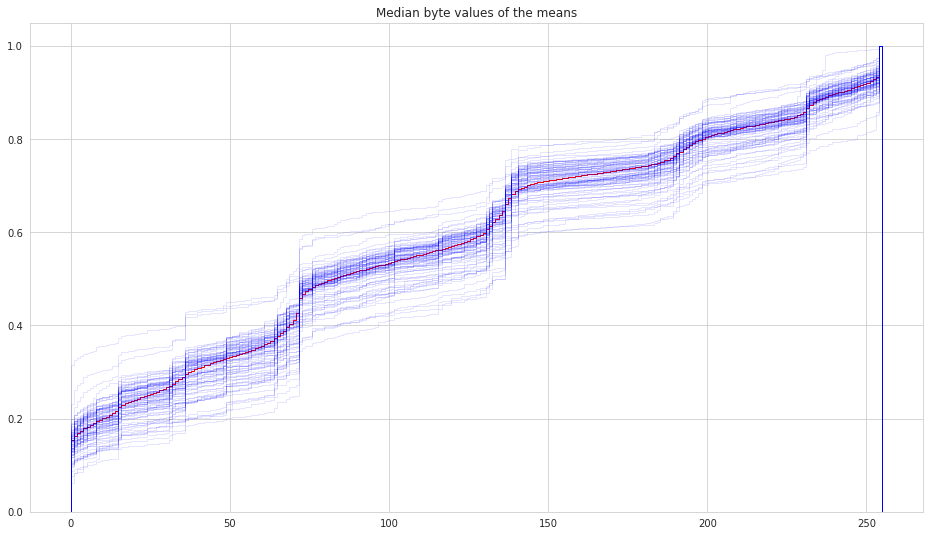

In [20]:
sns.distplot(mean, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Mean byte values of the means (red)")
plot_dists(code_dict)


sns.distplot(median, bins = 256, kde=False, hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1}, kde_kws={'cumulative': True}, norm_hist=True, color="red")

plt.title("Median byte values of the means")
plot_dists(code_dict)

The distribution of byte values of the **median of the means** looks to be more representative than the **mean of the means**.

In [22]:
from collections import Counter

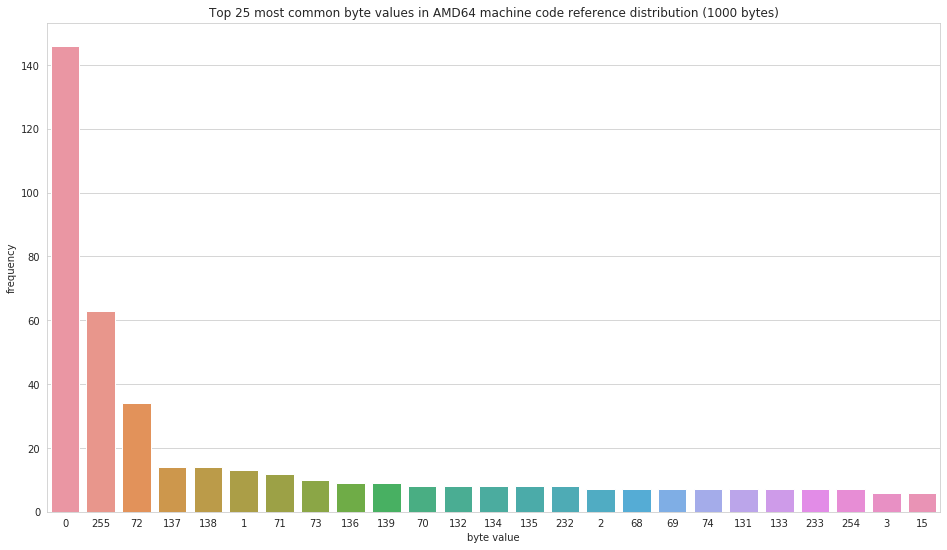

In [92]:
rounded_medians = [round(i) for i in median]
sorted_counts = sorted(Counter(rounded_medians).items(), key = lambda x: x[1], reverse=True)

counts_df = pd.DataFrame(sorted_counts[:25])
counts_df = counts_df.rename(columns={0:"byte value", 1:"frequency"})

sns.barplot(x="byte value", y="frequency", data=counts_df, order=counts_df["byte value"])
plt.title("Top 25 most common byte values in AMD64 machine code reference distribution (1000 bytes)")
plt.show()

In [88]:
[hex(i) for i in list(dict(sorted_counts).keys())[:25]]

['0x0',
 '0xff',
 '0x48',
 '0x89',
 '0x8a',
 '0x1',
 '0x47',
 '0x49',
 '0x88',
 '0x8b',
 '0x46',
 '0x84',
 '0x86',
 '0x87',
 '0xe8',
 '0x2',
 '0x44',
 '0x45',
 '0x4a',
 '0x83',
 '0x85',
 '0xe9',
 '0xfe',
 '0x3',
 '0xf']

In [205]:
# get pool of test files
test_pool = [file for file in files if file not in sample_files]

# select test files
np.random.seed(1)
test_files = np.random.choice(test_pool, size=3000, replace=False)

In [206]:
# check for overlap between files that the reference distribution was built from and the files used for testing
list(set(code_dict.keys()) & set(test_files))

[]

In [207]:
#path = "amd64/"

def extract_code(path, file_list, min_file_size=10000, n_files=1000):
    
    code_dict = {}
    counter = 0
    
    for file in file_list:
        with open(path + file, "rb") as f:
            try:
                elffile = ELFFile(f)
            except:
                continue
        
            try:
                text_section_header = elffile.get_section_by_name(".text").header
            except:
                continue
            offset = text_section_header.sh_offset
            size = text_section_header.sh_size
        
            if size >= min_file_size: # minimum size cutoff: 10kb of machine code
                counter += 1
                f.seek(offset)
                code_dict[file] = list(f.read(size))
                if counter == n_files: # number of files to select samples from
                    break
            else:
                continue
                
    return code_dict

In [208]:
test_code_dict = extract_code("amd64/", test_files)

In [209]:
for file, code in test_code_dict.items():
    print("%s\t%s\t%s" % (file, str(len(code)), code[:10]))

c0c6358c0d504b7ff8c012465c286861	195762	[72, 129, 236, 232, 0, 0, 0, 132, 192, 73]
285d5e56a4bdfacbb8ee785d7d0bd987	42954	[65, 87, 65, 86, 65, 85, 65, 84, 65, 137]
1a89eef0b49812ab1de84ce341c1b0cc	42578	[83, 72, 141, 29, 56, 46, 33, 0, 72, 139]
437161e4c44a639d64c473b0c30e0ba2	25458	[65, 87, 69, 49, 219, 185, 34, 0, 0, 0]
ef136ea421127935c87ac7ebeae41dbf	14642	[65, 86, 65, 85, 65, 84, 85, 137, 253, 83]
b39ec259554400a0861cb6a2a5e49cbb	134946	[80, 72, 139, 7, 72, 3, 120, 232, 139, 119]
7f891d1db078a975ca7561b1c48ea3e4	89426	[83, 72, 137, 251, 72, 131, 236, 16, 131, 254]
cf2f882028d79ecfcf7add696013a7f9	80802	[85, 83, 72, 137, 243, 137, 253, 72, 141, 13]
b3450f2806b1a69bef90cc5d2422c252	99954	[72, 131, 236, 8, 232, 151, 253, 255, 255, 190]
b53b9442636a27626d1c7ebe01e7407f	111442	[65, 86, 65, 85, 65, 84, 85, 83, 72, 129]
767eff969e82242147c439eace37ed0b	17714	[80, 191, 3, 0, 0, 0, 186, 209, 108, 64]
bd0da5ac94cf580865610ac9d20717b0	861042	[49, 237, 73, 137, 209, 94, 72, 137, 226, 72]
a8da

In [210]:
test_results_df = pd.DataFrame(index=test_code_dict.keys(),
                               columns=["size", "wasserstein distance","energy distance", "mean", "median", "standard deviation"])

for file, code in test_code_dict.items():
    test_results_df.loc[file]["size"] = len(code)
    test_results_df.loc[file]["wasserstein distance"] = stats.wasserstein_distance(median, code)
    test_results_df.loc[file]["energy distance"] = stats.energy_distance(median, code)
    test_results_df.loc[file]["mean"] = np.mean(code)
    test_results_df.loc[file]["median"] = np.median(code)
    test_results_df.loc[file]["standard deviation"] = np.std(code)
    
print(test_results_df.shape)
test_results_df

(1000, 6)


,size,wasserstein distance,energy distance,mean,median,standard deviation
c0c6358c0d504b7ff8c012465c286861,195762,6.71236,0.626786,99.0046,73,84.3222
285d5e56a4bdfacbb8ee785d7d0bd987,42954,2.18227,0.242204,106.702,85,85.1921
1a89eef0b49812ab1de84ce341c1b0cc,42578,5.78882,0.591768,106.195,83,90.4366
437161e4c44a639d64c473b0c30e0ba2,25458,6.52837,0.65642,108.583,88,90.8175
ef136ea421127935c87ac7ebeae41dbf,14642,2.16421,0.244823,105.315,84,87.757
...,...,...,...,...,...,...
6cc5a56de6ce91a4de47b05a98732bf8,77754,3.26883,0.353905,102.853,76,85.4233
a060b916443dd1fc47350c4ce4dfd4d9,156498,4.42172,0.518453,103.975,80,83.6401
36a891a2cb409bb18782f5bc7f5349b4,11170,10.1224,1.18579,115.225,116,83.0799
5d19f93b9c2aa5ff7039bb8e5568a99d,16834,3.72539,0.409217,102.127,72,85.7898


In [225]:
test_results_df.mean()

size                    270779.409000
wasserstein distance         7.629869
energy distance              0.747302
mean                       105.615225
median                      86.292500
standard deviation          86.033276
dtype: float64

In [226]:
test_results_df.median()

size                    50999.000000
wasserstein distance        5.221571
energy distance             0.539445
mean                      105.323231
median                     81.000000
standard deviation         86.108752
dtype: float64

In [213]:
test_results_df["size"].sum()

270779409

In [214]:
test_results_df["size"].sum() / 1000000

270.779409

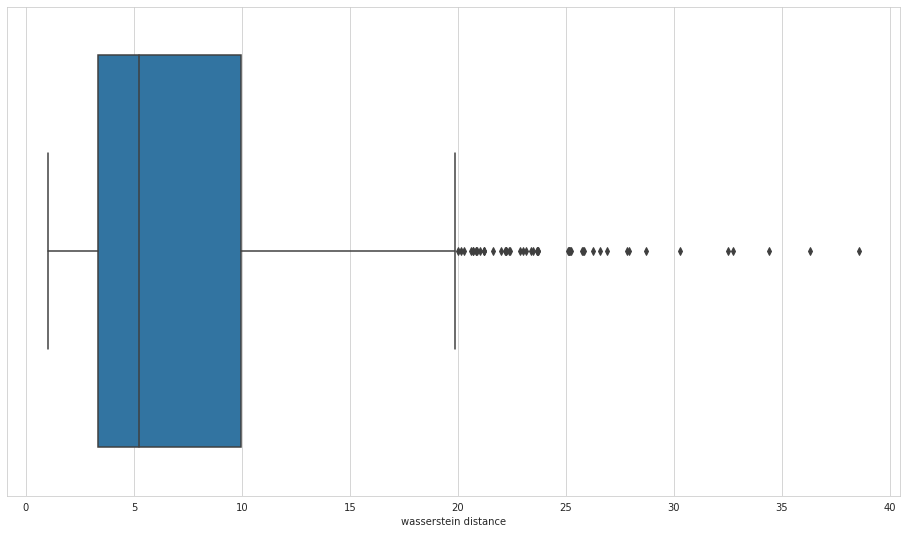

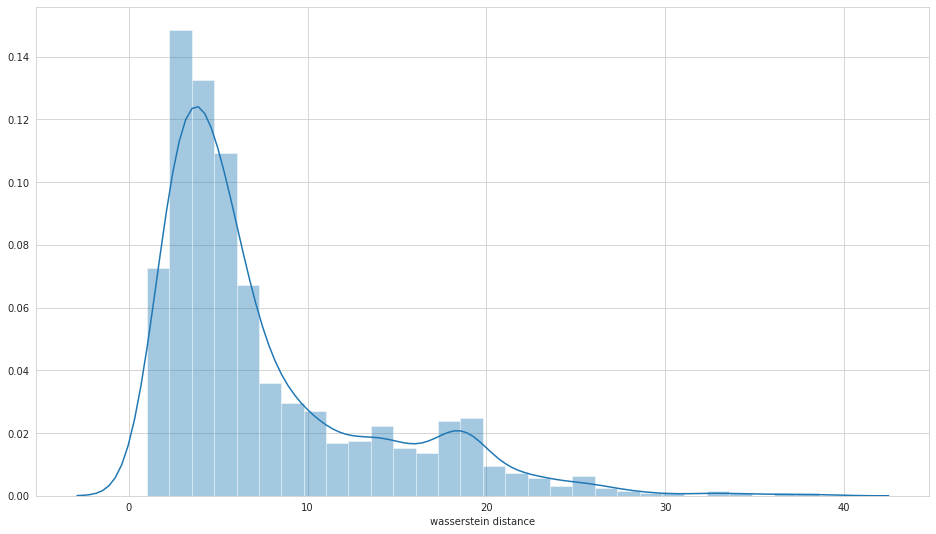

In [215]:
sns.boxplot(x="wasserstein distance", data=test_results_df)
plt.show()
sns.distplot(test_results_df["wasserstein distance"], bins=30)
plt.show()

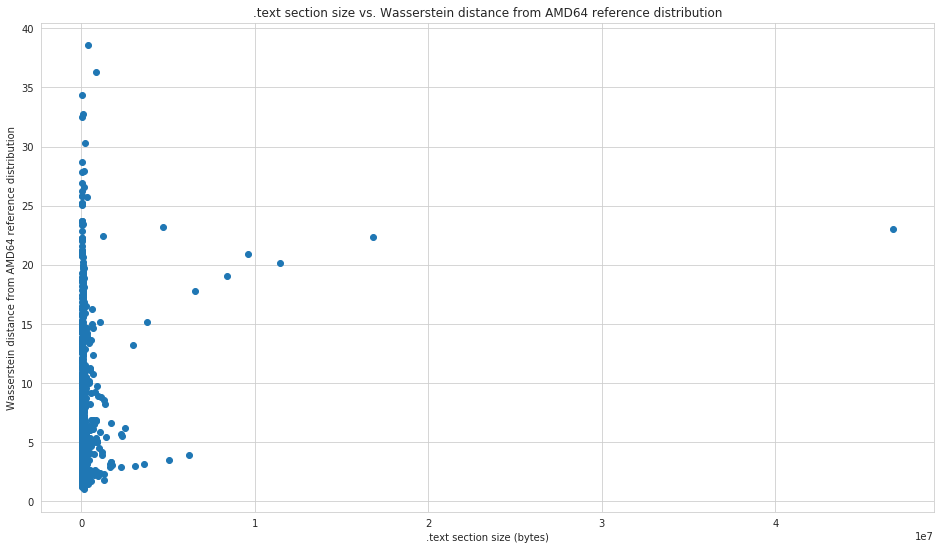

In [216]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from AMD64 reference distribution")
plt.title(".text section size vs. Wasserstein distance from AMD64 reference distribution")
plt.show()

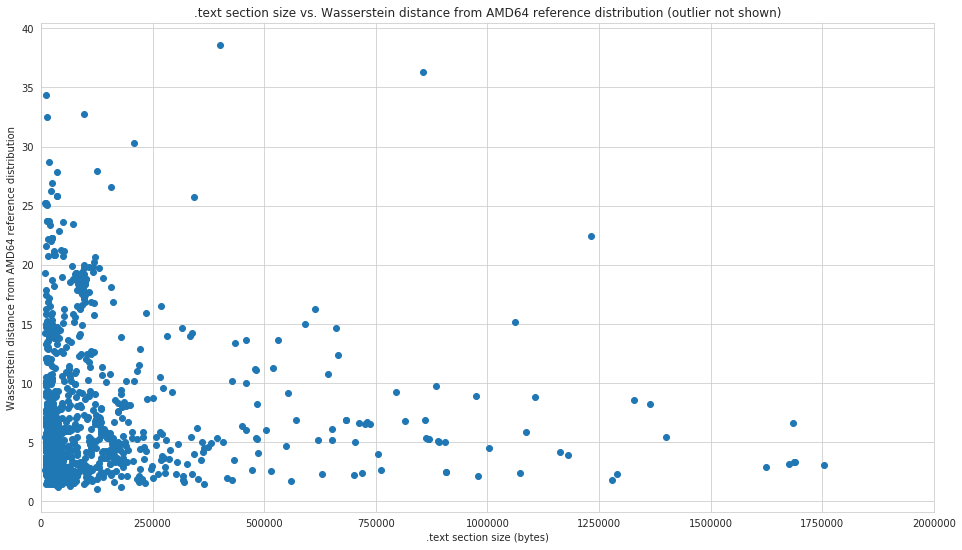

In [217]:
plt.scatter(test_results_df["size"], test_results_df["wasserstein distance"])
plt.xlabel(".text section size (bytes)")
plt.ylabel("Wasserstein distance from AMD64 reference distribution")
plt.title(".text section size vs. Wasserstein distance from AMD64 reference distribution (outlier not shown)")
plt.xlim(0, 2000000)
plt.show()

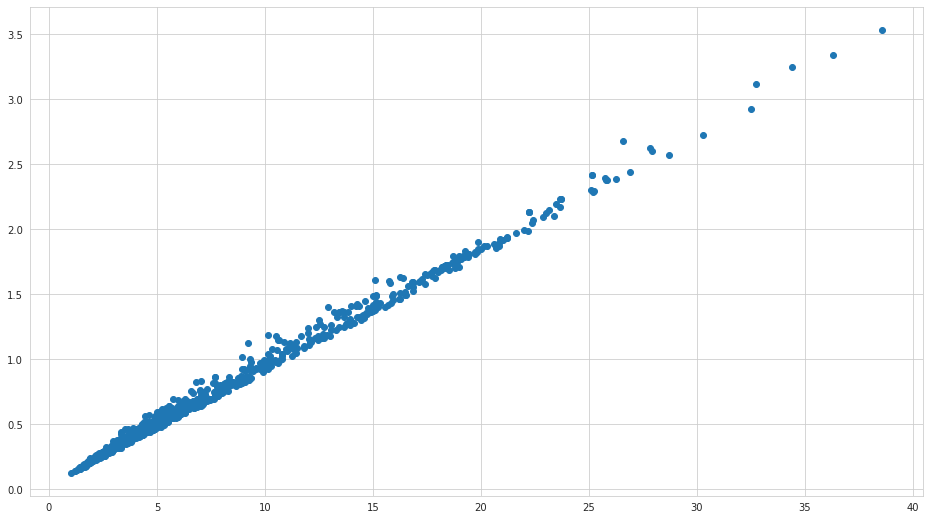

In [218]:
plt.scatter(test_results_df["wasserstein distance"], test_results_df["energy distance"])

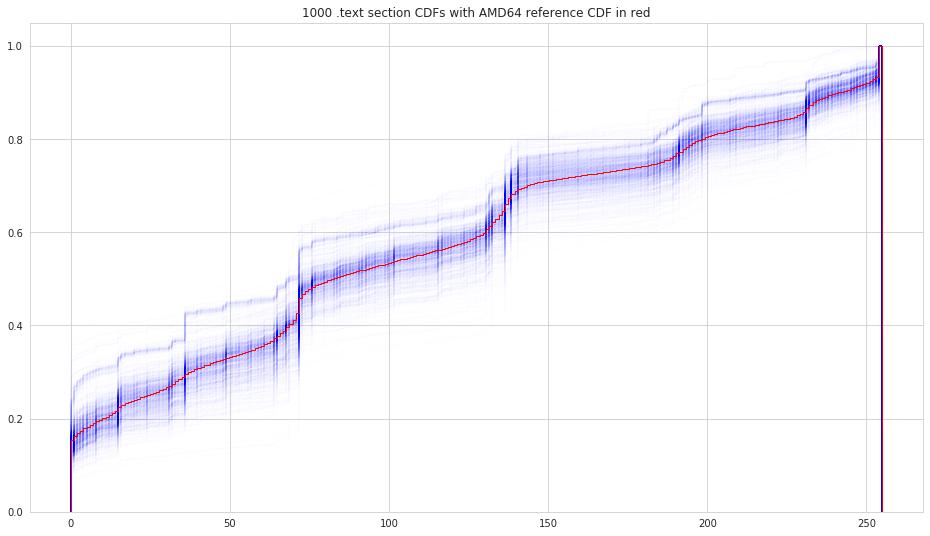

In [223]:
for code in test_code_dict.values():
    plot_sample(code)
    
sns.distplot(median, # reference distribution
             norm_hist=True,     
             kde=False,
             hist_kws={'histtype':'step', 'cumulative': True, 'linewidth':1, 'alpha':1},
             kde_kws={'cumulative': True},
             bins=256,                      
             color="red")

plt.title("1000 .text section CDFs with AMD64 reference CDF in red")
plt.show()

In [222]:
# export reference distribution
with open("AMD64_reference", "wb") as f:
    pickle.dump(median, f)